In [1]:
# os
import os

# データ整形用
import pandas as pd

# ベイズ最適化
import optuna

# 構造学習用
from causalnex.structure.notears import from_pandas_lasso
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

# ベイジアンネットワーク
from causalnex.network import BayesianNetwork
from causalnex.inference import InferenceEngine

# AUCの計算用
from sklearn.metrics import roc_auc_score
from causalnex.evaluation import classification_report, roc_auc
from sklearn.model_selection import train_test_split


# 可視化用
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import networkx as nx

/home/yarita/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_excel('../data/231021-1110_AI用qPCRデータ.xlsx', header=1, index_col=0)
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(211, 33)

In [3]:
# 平均0, 分散1の標準化
scaler = StandardScaler()
norm_data_array = scaler.fit_transform(data)
norm_data = pd.DataFrame(norm_data_array, columns=data.columns)
norm_data.head(3)

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,-0.478000,-0.145310,-0.186724,-0.126510,-0.296711,-0.196438,-0.139036,-0.099555,-0.150187,-0.270711,...,-0.304500,0.040025,-1.144075,0.233070,-0.251672,-0.181602,-0.634371,-0.893224,-0.429545,-0.422568
1,-0.383090,-0.128682,-0.145902,-0.489821,-0.295543,-0.142752,-0.133647,-0.091603,-0.063683,-0.124194,...,-0.152559,0.058741,-1.142809,0.286622,-0.169224,0.018884,-0.543704,-0.337397,-0.029556,-0.000408
2,-0.383244,-0.603811,-0.145725,-0.490193,-0.202170,-0.196047,0.304820,-0.097057,-0.150002,0.169103,...,-0.153226,0.047084,-1.135013,0.269307,-0.167799,0.018553,-0.361239,-0.327326,-0.023438,0.014527


X (DataFrame) – input data.
beta (float) – Constant that multiplies the lasso term.
max_iter (int) – max number of dual ascent steps during optimisation.
h_tol (float) – exit if h(W) < h_tol (as opposed to strict definition of 0).
w_threshold (float) – fixed threshold for absolute edge weights.

### データの離散化
#### 2値分類（中央値で分類）

In [4]:
# Discretize the features
# Excluding the first column which seems to be an index or identifier
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(norm_data.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=norm_data.columns)

/home/yarita/.local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


#### 注意点
- w_thresholdの探索範囲: 0.0 - 5.0など，maxを大きい値にするとベイジアンネットワークの構築ができず，エラーが出てしまうので，1つの連結されたネットワークである必要があるので，1.0にしている．1.0であれば，1つの連結されたネットワークになるので，エラーが出ない．

In [5]:
# ベイズ最適化
def objective(trial):
    # train, test = train_test_split(discretised_data, train_size=0.8, random_state=42)
    
    # max_iter = trial.suggest_int('max_iter', 100, 1000)
    # w_threshold = trial.suggest_float('w_threshold', 1e-4, 0.5)
    beta = trial.suggest_float('beta', 1e-8, 1, log=True)  # ログスケールでlassoの値を探索(探索範囲は広め)

    # NOTEARSアルゴリズムを用いて構造学習を実施
    # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
    sm, loss_values = from_pandas_lasso(norm_data,
                        #    max_iter=max_iter,
                        #    w_threshold=w_threshold,
                           beta=beta
                           )

    # bn = BayesianNetwork(sm)

    # bn = bn.fit_node_states(norm_data)
    # bn = bn.fit_cpds(train)

    # # AUCを計算
    # _, auc = roc_auc(bn, test, "pgi")

    # # 損失関数をスコアとして，最小化する

    # print("\nAUC: {}".format(auc))

    return loss_values[-1]

# スコア(loss_values)を最小化
study = optuna.create_study(direction='minimize')
# 最大化
# study = optuna.create_study(direction='maximize')

# 100回の試行で最適化
study.optimize(objective, n_trials=100)
# ログ非表示
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 最適なハイパーパラメータを出力
best_params = study.best_params

[I 2024-01-12 15:15:58,832] A new study created in memory with name: no-name-b9683802-3e1b-4809-8c45-6c26002d4732
[I 2024-01-12 15:17:15,321] Trial 0 finished with value: 2.6565736164801423 and parameters: {'beta': 2.8190835322615157e-07}. Best is trial 0 with value: 2.6565736164801423.
[I 2024-01-12 15:18:04,294] Trial 1 finished with value: 2.513143626309489 and parameters: {'beta': 0.0018726058117231356}. Best is trial 1 with value: 2.513143626309489.
[I 2024-01-12 15:19:07,116] Trial 2 finished with value: 2.7061083436320663 and parameters: {'beta': 0.0032960299585580092}. Best is trial 1 with value: 2.513143626309489.
[I 2024-01-12 15:20:37,107] Trial 3 finished with value: 2.449153916275277 and parameters: {'beta': 3.1689791625986985e-05}. Best is trial 3 with value: 2.449153916275277.
[I 2024-01-12 15:21:56,393] Trial 4 finished with value: 2.6495154702041974 and parameters: {'beta': 1.0337357635113897e-07}. Best is trial 3 with value: 2.449153916275277.
[I 2024-01-12 15:23:23,0

In [6]:
best_params

{'beta': 0.00025230781656426353}

[1.6324544564455385, 1.8333713475264768, 2.0058628165306924, 2.0524232573456267, 2.080466978850371, 2.120773753411272, 2.1758744350252193, 2.2228589934679963, 2.199253614260133, 2.236288292544816]
['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']
[('agp', 'tpiA'), ('yihX', 'fbaB'), ('yihX', 'pgk'), ('yihX', 'pykF'), ('yihX', 'ppsA'), ('pgm', 'pfkB'), ('ptsG', 'glk'), ('malx', 'ptsG'), ('malx', 'galM'), ('malx', 'pgi'), ('malx', 'glpX'), ('malx', 'fbp'), ('malx', 'fbaB'), ('malx', 'pgk'), ('malx', 'gpmA'), ('malx', 'ppsA'), ('galM', 'agp'), ('galM', 'pgm'), ('galM', 'fbaB'), ('galM', 'eno'), ('galM', 'ppsA'), ('yihR', 'glk'), ('yihR', 'yihX'), ('yihR', 'pgm'), ('yihR', 'crr'), ('yihR', 'ascB'), ('yihR', 'yggF'), ('yihR', 'fbaB'), ('yihR', 'pgk'), ('yihR', 'eno'), ('yihR', 'pykF'), ('

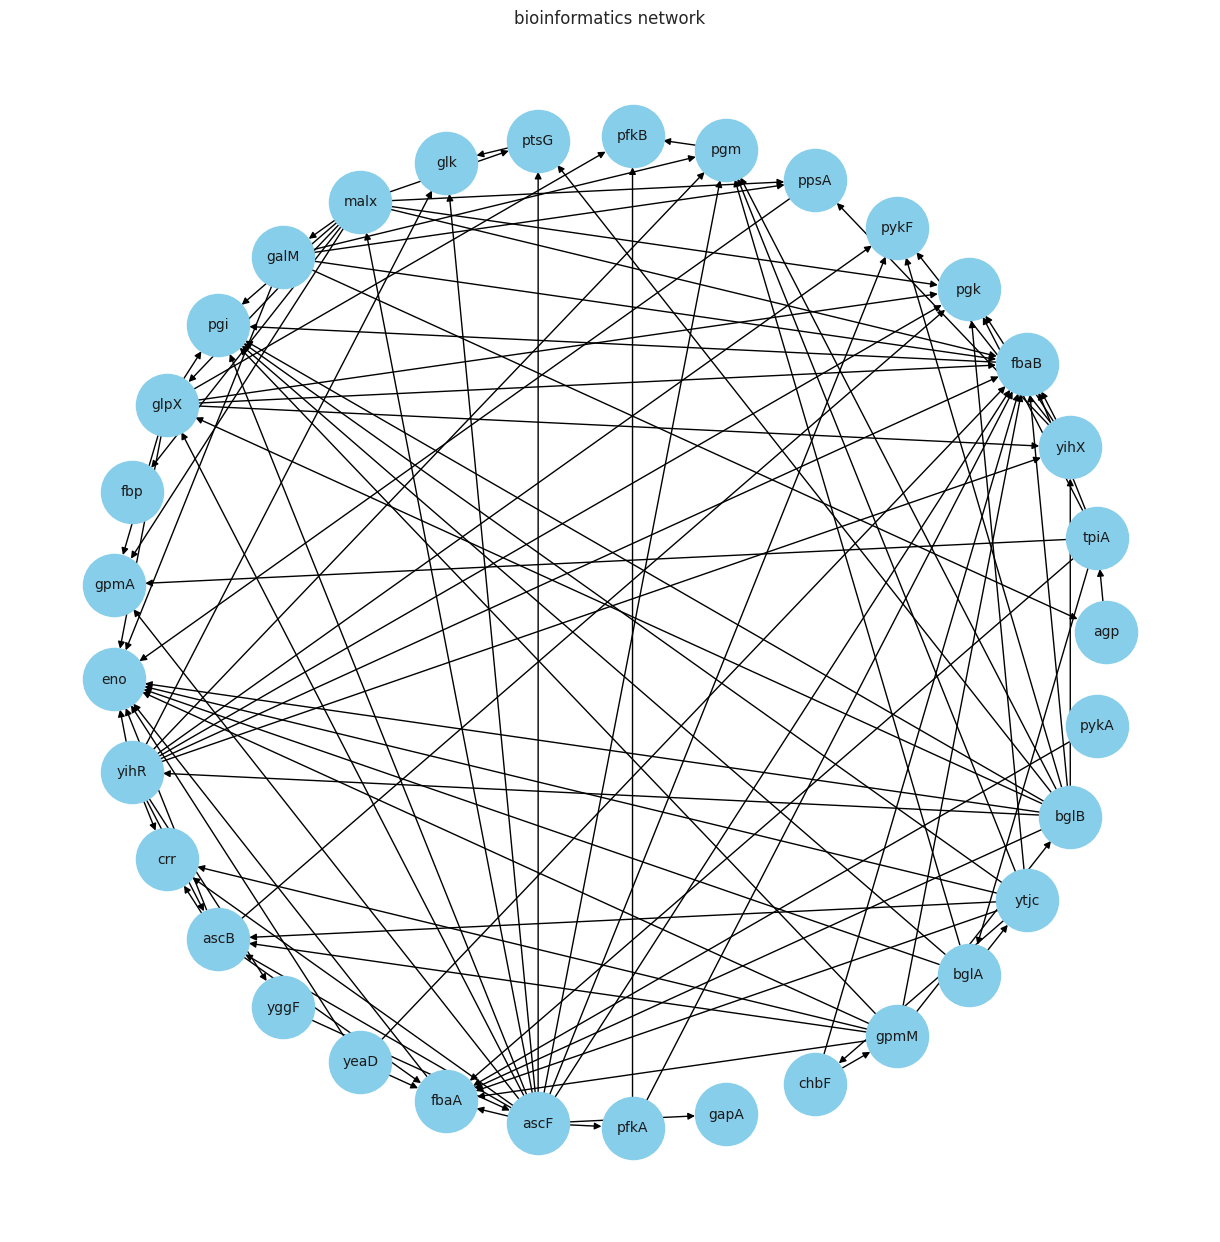

In [9]:
train, test = train_test_split(discretised_data, train_size=0.8, random_state=42)

beta=best_params['beta']
max_iter=1000       # 一旦1000で固定
w_threshold=0.5
# w_threshold=1


result_tuple = from_pandas_lasso(X=norm_data, beta=beta, max_iter=max_iter, w_threshold=w_threshold)
sm, loss_values = result_tuple

print(loss_values)

print(sm.nodes())
print(sm.edges())

# 連番生成関数
def create_filename(base_name, directory='.', extension='.png'):
    counter = 1
    while True:
        file_name = f"{base_name}_{counter}{extension}"
        full_path = os.path.join(directory, file_name)
        if not os.path.exists(full_path):
            return full_path
        counter += 1

def draw_graph(sm, w_threshold):
    sns.set(style="whitegrid")

    # 構造モデルsmをnetworkxのグラフに変換
    G = nx.DiGraph(sm.edges())

    # グラフの描画
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)  # ノードの配置
    nx.draw(G, pos, with_labels=True, node_size=2000, edge_color="black", node_color="skyblue", font_size=10)
    plt.title("bioinformatics network")
    plt.savefig(f"./bio_networks/bio_network_th{w_threshold}.png", format="png", dpi=300, bbox_inches='tight')

draw_graph(sm, w_threshold)

In [10]:
bn = BayesianNetwork(sm)

bn = bn.fit_node_states(norm_data)
bn = bn.fit_cpds(train)

# AUCを計算
_, auc = roc_auc(bn, test, "pgi")

print("\nAUC: {}".format(auc))

ValueError: The given structure is not acyclic. Please review the following cycle: [('agp', 'tpiA'), ('tpiA', 'bglA'), ('bglA', 'ytjc'), ('ytjc', 'chbF'), ('chbF', 'gpmM'), ('gpmM', 'bglB'), ('bglB', 'yihR'), ('yihR', 'yggF'), ('yggF', 'ascF'), ('ascF', 'malx'), ('malx', 'galM'), ('galM', 'agp')]